#Code to check DMDs for individual TOV solutions

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Code edited from tovClass.py

import numpy as np
import sys
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
plt.style.use("default")
from scipy.interpolate import interp1d
from matplotlib.ticker import ScalarFormatter
# from tqdm import tqdm
from scipy.sparse import diags
from scipy.optimize import fsolve
from scipy.optimize import minimize
# from cycler import cycler
sys.path.append('../')
# from tovScaledRev import TOV as TOV1
# from scaledTOV import TOV
from src import TOV_class

# constants
r0 = 8.378  # km
m0 = 2.837  # solar mass
alphaG = 5.922e-39  # constant
lambda_n = 2.10e-19  # km
rSun = 2.953  # Schwarzschild Radius of sun in km
eps0 = 1.285e3  # MeV/fm^3
pres0 = 1.285e3  # MeV/fm^3
msol = 1.116e60  # Mass of sun in MeV
Ggrav = 1.324e-42  # Mev^-1*fm
rsol = 2.954e18
# Schwarrzschild radius of the sun in fm
rhosol = msol * 3 / (4.0 * np.pi * rsol**3)

In [4]:
# tov = TOV("../EOS_files/sorted_Sly4.dat", 100)
# tov1 = TOV1("../EOS_files/sortedSly4_eos.dat", 100, tidal=True)
tov = TOV_class.TOVsolver("./EOS_Data/sorted_Sly4.dat", True, solver="RK4", sol_pts=2500)
# tov = TOV_class.TOVsolver("./EOS_Data/sorted_Sly4.dat", True, solver="solve_ivp", solve_ivp_kwargs={"method": "RK45",
#                                                                                                     "atol": 1e-12,
#                                                                                                     "rtol": 1e-12})
R_max=20.0

Woo it worked!


In [5]:
# pvals = np.geomspace(1e-3, 2.0)
# Sols_varying_p0=[]
# # Sols_varying_p0_1=[]

# # Solve TOV equations for different central pressures
# # and store the solutions in Sols_varying_p0
# # returns rdata, pressure, mass
# for p0 in pvals:
#     # result = tov.tovsolve(p0, R_max)
#     # result1 = tov1.tovsolve(p0)
#     # Sols_varying_p0_1.append(result1)
#     result = tov.tov_routine(p0=p0 / pres0)
#     Sols_varying_p0.append(result)
#     # print(result)
# # print(Sols_varying_p0_1[0], len(Sols_varying_p0_1[0][0]))

In [6]:
result = tov.tov_routine()

pres_init = 1.0
Max mass:  2.067201 Radius:  10.059465 Central pressure:  841.840196


In [7]:
pvals = tov.pvals
Sols_varying_p0 = tov.sols

len(Sols_varying_p0[0][1])

1918

In [8]:
# pvals = list(tov.sols[:, 0, :])
# Sols_varying_p0 = list(tov.sols[:, 1:, :])
# np.shape(Sols_varying_p0)

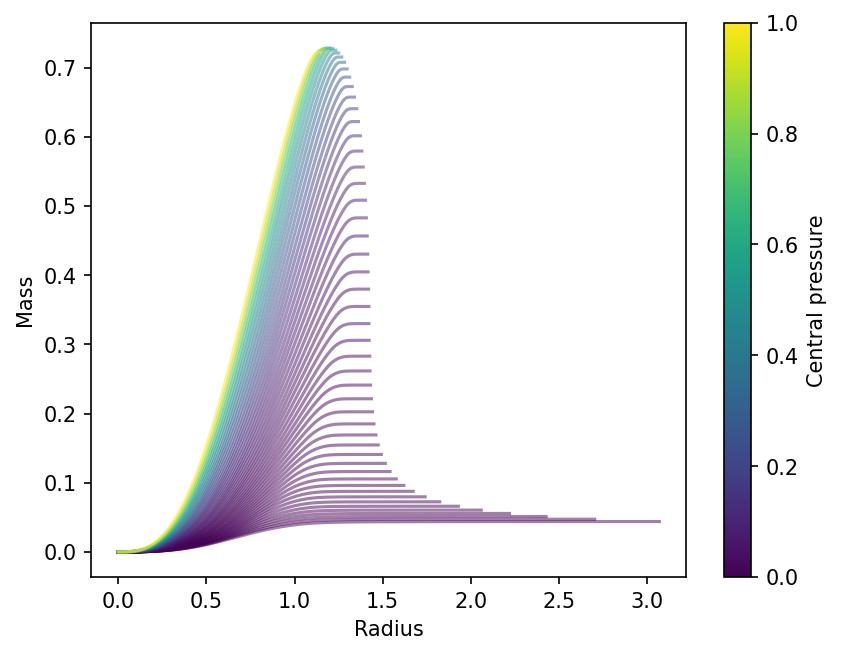

In [9]:
fig, ax = plt.subplots(dpi=150)

for i in range(len(Sols_varying_p0)):
    ax.plot(Sols_varying_p0[i][0],Sols_varying_p0[i][2], alpha=0.5 ,color=plt.cm.viridis(pvals[i]), label=f"R_{pvals[i]:.2f}")
    # ax.plot(Sols_varying_p0_1[i][0],Sols_varying_p0_1[i][2], alpha=0.5,color=plt.cm.viridis(pvals[i]), label=f"P_{pvals[i]:.2f}")

sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Central pressure')

ax.set_ylabel("Mass")
ax.set_xlabel("Radius")

# plt.legend(prop={"size": 4}, loc='upper right')
plt.savefig('MvsR.pdf')
plt.show()

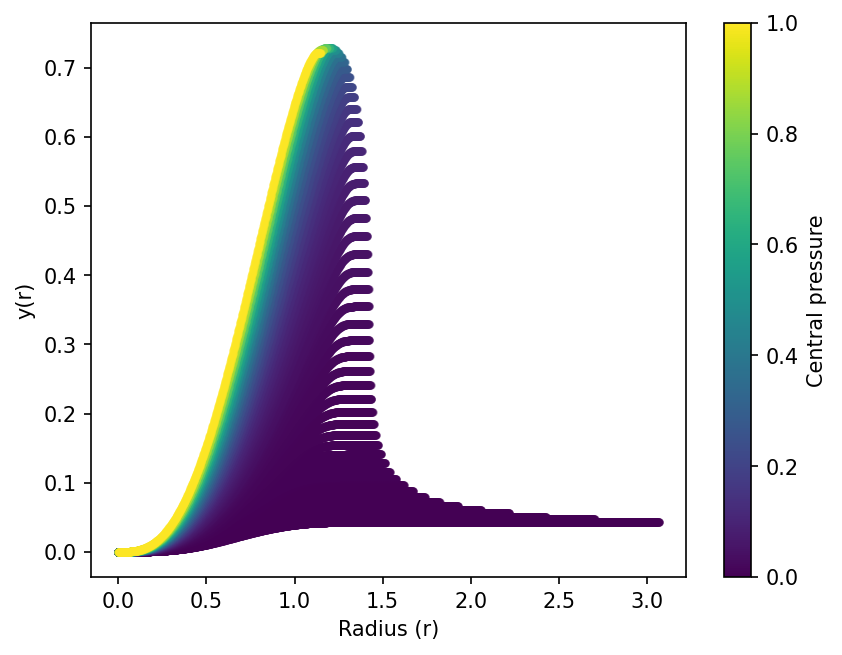

In [10]:
fig, ax = plt.subplots(dpi=150)

for i in range(len(Sols_varying_p0)):
    ax.plot(Sols_varying_p0[i][0],Sols_varying_p0[i][2],'.', alpha=0.5,color=plt.cm.viridis(pvals[i]), label=f"R_{pvals[i]:.2f}")
    # ax.plot(Sols_varying_p0_1[i][0],Sols_varying_p0_1[i][3], alpha=0.5,color=plt.cm.viridis(pvals[i]), label=f"P_{pvals[i]:.2f}")

sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Central pressure')

ax.set_ylabel("y(r)")
ax.set_xlabel("Radius (r)")

# plt.legend(prop={"size": 4}, loc='upper right')
plt.savefig('MvsR.pdf')
plt.show()

In [11]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

intPres = []
intMasses = []
intRadii = []
idx = np.arange(100)



for i, sol in enumerate(Sols_varying_p0):
    x = np.linspace(0, 1, len(sol[0])) 
    y = Sols_varying_p0[i][0]
    spline = UnivariateSpline(x, y, s=0)  # s=0 for interpolation (through all points)
    x_new = np.linspace(0, 1, 40)  # Adjust 500 for more/less points
    r = spline(x_new)
    f_m = interp1d(sol[0], sol[2], kind='cubic', fill_value='extrapolate')
    f_p = interp1d(sol[0], sol[1], kind='cubic', fill_value='extrapolate')
    # f_r = interp1d(idx, sol[0], kind='cubic', fill_value='extrapol
    # r = np.geomspace(sol[0][-1], sol[0][0], len(Sols_varying_p0_1[i][0]))
    # r = Sols_varying_p0_1[i][0]
    m = f_m(r)
    p = f_p(r)
    signArray = (np.diff(np.sign(p)) != 0)*1
    intVal = np.where(signArray == 1)
    if intVal[0].size > 0:
        intPres.append(p[:intVal[0][0]])
        intMasses.append(m[:intVal[0][0]])
        intRadii.append(r[:intVal[0][0]])
    else:
        intPres.append(p)
        intMasses.append(m)
        intRadii.append(r)


In [12]:
# # plt.plot(Sols_varying_p0[-1][0], label = "dp/dr")
# plt.plot(Sols_varying_p0_1[-1][0], label = "dr/dp")
# plt.plot(intRadii[-1],'.', label = "dp/dr Interp")
# plt.legend()
# plt.show()

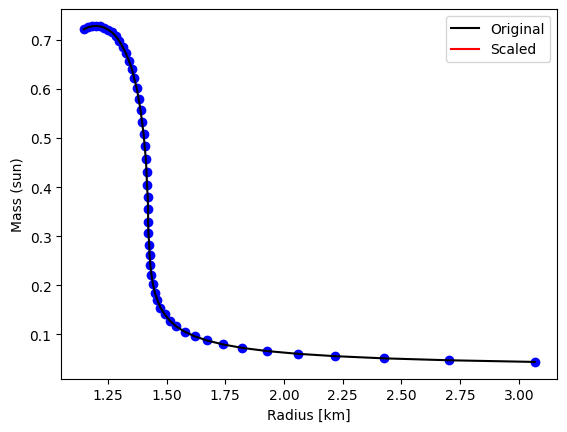

In [13]:
fig, ax = plt.subplots()
Masses=[]
Radii=[]
Masses1=[]
Radii1=[]
intMass = []
intRad = []
for i in range(len(Sols_varying_p0)):
    Masses.append(Sols_varying_p0[i][2][-1])
    Radii.append(Sols_varying_p0[i][0][-1])
    # Masses1.append(Sols_varying_p0_1[i][2][-1])
    # Radii1.append(Sols_varying_p0_1[i][0][-1])
    intMass.append(intMasses[i][-1])
    intRad.append(intRadii[i][-1])

ax.plot(Radii, Masses,label="Original",color='k')
# ax.scatter(Radii, Masses,color='k')
ax.plot(Radii1, Masses1,label="Scaled",color='r')
# ax.scatter(Radii1, Masses1,color='r')
# ax.plot(intRad, intMass,label="Interpolated",color='b')
ax.scatter(intRad, intMass,color='b')
# ax.set_yscale('log')
# ax.set_xlim(10,18)
ax.set_xlabel("Radius [km]")
ax.set_ylabel("Mass (sun)")
plt.legend()
plt.savefig("massvsRad.pdf")
plt.show()

(14, 128) 4
(14, 113) 4
(14, 102) 4
(14, 93) 4
(14, 86) 4
(14, 81) 4
(14, 76) 4
(14, 73) 4
(14, 70) 4
(14, 68) 4
(14, 66) 4
(14, 65) 4
(14, 64) 4
(14, 63) 4
(14, 62) 4
(14, 61) 4
(14, 61) 4
(14, 61) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 60) 4
(14, 59) 4
(14, 59) 4
(14, 59) 4
(14, 59) 4
(14, 59) 4
(14, 59) 4
(14, 58) 4
(14, 58) 4
(14, 58) 4
(14, 57) 4
(14, 57) 4
(14, 56) 4
(14, 56) 4
(14, 55) 4
(14, 55) 4
(14, 54) 4
(14, 53) 4
(14, 53) 4
(14, 52) 4
(14, 51) 4
(14, 50) 4
(14, 50) 4
(14, 49) 4
(14, 48) 4
Lam [8.43652141e+00+0.j         2.53435953e-03+0.j
 3.81544880e-01+0.j         1.38993670e+00+0.j
 7.16480622e-01+0.j         9.21510376e-01+0.j
 9.77588236e-01+0.13001295j 9.77588236e-01-0.13001295j
 1.03513419e+00+0.06304482j 1.03513419e+00-0.06304482j]


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_13862/413385703.py:47: RuntimeWarning: overflow encountered in exp
  pres_DMD = np.exp(Xdmd[1].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_13862/413385703.py:49: RuntimeWarning: overflow encountered in exp
  y_dmd = np.exp(Xdmd[3].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_13862/413385703.py:46: RuntimeWarning: overflow encountered in exp
  rad_DMD = np.exp(Xdmd[0].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_13862/413385703.py:48: RuntimeWarning: overflow encountered in exp
  mass_DMD = np.exp(Xdmd[2].real)


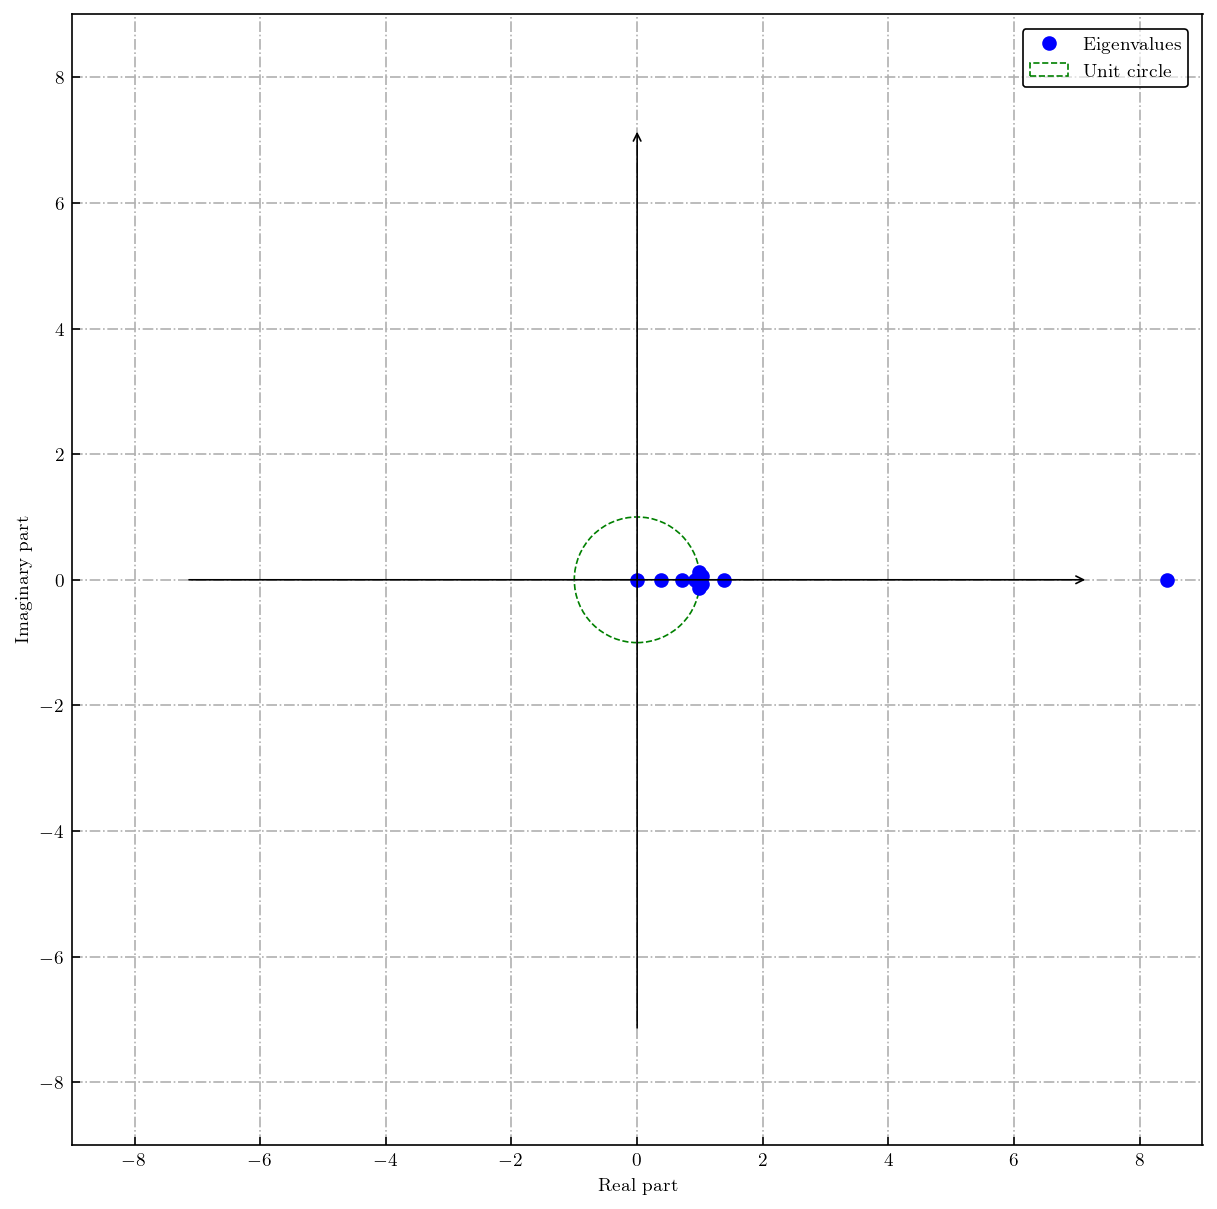

In [41]:
# Introduce the DMD routine
# from DMDScript import *
import sys
sys.path.append("./src")
from src.SLM import *

presDMDArray = []
radDMDArray = []
massDMDArray = []
yDMDArray = []
n = 15
svdSize = 10

# Order of data, r, p, m, rho
for sol in Sols_varying_p0:
    
    # print(len(intRadii[i][1:][::n]))
    # r = intRadii[i][1:][::n].copy()
    # p = intPres[i][1:][::n].copy()
    # m = intMasses[i][1:][::n].copy()
    r = sol[0][1:][::n].copy()   
    p = sol[1][1:][::n].copy()
    m = sol[2][1:][::n].copy()
    y = sol[3][1:][::n].copy()
    # eps = Sols_varying_p0[i][3][1:][::n].copy()
    # rho = Sols_varying_p0[i][3]
    # print('mass', m, p, r, m.shape, p.shape, r.shape)
    
    X = [np.log(r), np.log(p), np.log(m), np.log(y)]
    # X = [r, p, m]
    X = np.asarray(X, dtype=np.float64)
    
    # Filter out inf and NaN values
    # X = X[:, ~np.isnan(X).any(axis=0) & ~np.isinf(X).any(axis=0)]
    
    linT = np.arange(len(p))
    # phi, omega, lam, b, Xdmd, S = DMD(X, svdSize, (linT[-1] - linT[0]))
    SLM_run = DMD(X, svdSize, (linT[-1] - linT[0]))  
    phi = SLM_run[0]
    omega = SLM_run[1]
    lam = SLM_run[2]
    b = SLM_run[3]
    Xdmd = SLM_run[4]
    S = SLM_run[5]
    
    rad_DMD = np.exp(Xdmd[0].real)
    pres_DMD = np.exp(Xdmd[1].real)
    mass_DMD = np.exp(Xdmd[2].real)
    y_dmd = np.exp(Xdmd[3].real)
    
    # print(rad_DMD)
    # rad_DMD = Xdmd[0].real
    # pres_DMD = Xdmd[1].real
    # mass_DMD = Xdmd[2].real
    # idx = np.where(np.array(pres_DMD>0))[0][-1]
    # print(idx, pres_DMD[:idx])

    # print(mass_DMD)
    presDMDArray.append(pres_DMD)
    radDMDArray.append(rad_DMD)
    massDMDArray.append(mass_DMD)
    yDMDArray.append(y_dmd)

    # presDMDArray.append(pres_DMD[:idx])
    # radDMDArray.append(rad_DMD[:idx])
    # massDMDArray.append(mass_DMD[:idx])

print("Lam", lam)
plot_eigs(lam)
# print(radDMDArray[0], massDMDArray[0], presDMDArray[0]) 

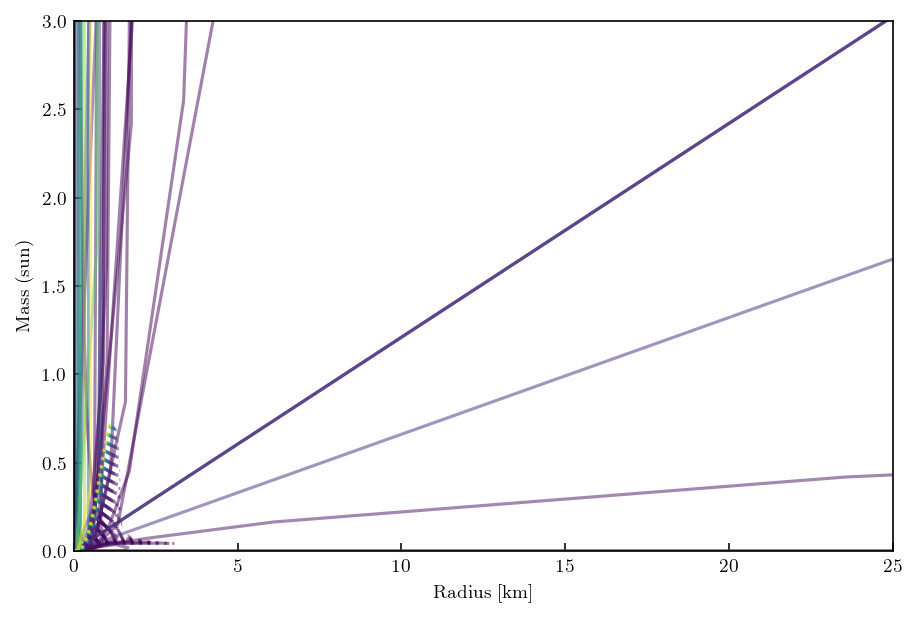

In [42]:
# Plot the data
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
for i in range(len(Sols_varying_p0)):
    ax.plot(Sols_varying_p0[i][0],Sols_varying_p0[i][2], alpha=0.5,color=plt.cm.viridis(pvals[i]),linestyle='dotted', label=f"{pvals[i]:.2f}")
    # ax.plot(Sols_varying_p0_1[i][0],Sols_varying_p0_1[i][2], alpha=0.5,color=plt.cm.viridis(pvals[i]),linestyle='dotted', label=f"{pvals[i]:.2f}")
    if i < len(radDMDArray) and i < len(massDMDArray):
        ax.plot(radDMDArray[i], massDMDArray[i], alpha=0.5,color=plt.cm.viridis(pvals[i]))

plt.xlim(0, 25)
plt.ylim(0, 3)
plt.xlabel("Radius [km]")
plt.ylabel("Mass (sun)")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

plt.savefig("massvsRadDMD.pdf")

In [46]:
massDMDArray

[array([1.52178990e-09, 1.70240687e-06, 1.25863779e-05, 4.15962529e-05,
        1.00068983e-04, 1.97779086e-04, 3.41821745e-04, 5.37621153e-04,
        7.90136259e-04, 1.10454712e-03, 1.48641274e-03, 1.94149845e-03,
        2.47545111e-03, 3.09343322e-03, 3.79977389e-03, 4.59766406e-03,
        5.48890809e-03, 6.47373640e-03, 7.55068064e-03, 8.71651113e-03,
        9.96623511e-03, 1.12931537e-02, 1.26889746e-02, 1.41439752e-02,
        1.56472131e-02, 1.71867736e-02, 1.87500494e-02, 2.03240407e-02,
        2.18956659e-02, 2.34520720e-02, 2.49809327e-02, 2.64707237e-02,
        2.79109657e-02, 2.92924263e-02, 3.06072749e-02, 3.18491872e-02,
        3.30133976e-02, 3.40967010e-02, 3.50974074e-02, 3.60152549e-02,
        3.68512874e-02, 3.76077053e-02, 3.82876971e-02, 3.88952603e-02,
        3.94350179e-02, 3.99120392e-02, 4.03316692e-02, 4.06993708e-02,
        4.10205848e-02, 4.13006079e-02, 4.15444914e-02, 4.17569597e-02,
        4.19423486e-02, 4.21045631e-02, 4.22470516e-02, 4.237279

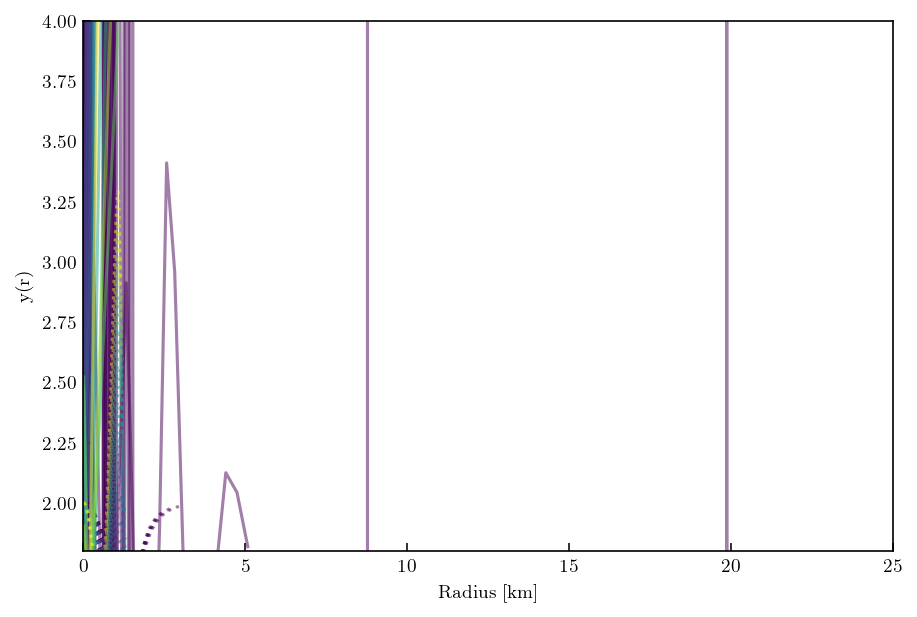

In [29]:
# Plot the data
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
for i in range(len(Sols_varying_p0)):
    ax.plot(Sols_varying_p0[i][0],Sols_varying_p0[i][3], alpha=0.5,color=plt.cm.viridis(pvals[i]),linestyle='dotted', label=f"{pvals[i]:.2f}")
    if i < len(radDMDArray) and i < len(massDMDArray):
        ax.plot(radDMDArray[i], yDMDArray[i], alpha=0.5,color=plt.cm.viridis(pvals[i]))

plt.xlim(0, 25)
plt.ylim(1.8,4)
plt.xlabel("Radius [km]")
plt.ylabel("y(r)")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()

plt.savefig("massvsRadDMD.pdf")

In [30]:
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
import sys
sys.path.append("./../")
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()


In [31]:

# define some useful figure things
dpi = 600
figsize = (5, 5)  # Goddam that is one big fig. Might make one giant Newton.
save_figures = True
save_location = "./../Plots"

tov_alpha = 0.55
dmd_alpha = 0.7
res_alpha = 0.6
scatter_size = 20
tick_size = 24
axis_label_size = 24

res_axis_label_size = 18
tov_linewidth = 2.75
dmd_dot_size = 33
res_linewidth = 3

title_size = 24
legend_size = 8

res_width = "60%"
res_height = 2.5


# cmap_min = 0.25
# cmap_max = 0.85
cmap_min = 0.15
cmap_max = 0.85
colors = plt.cm.plasma(np.linspace(cmap_min, cmap_max, len(pvals)))

In [32]:
dpi = 1200
fig, ax = plt.subplots(1, 3, dpi=dpi, figsize=(3 * figsize[1], figsize[0]), constrained_layout=True)
fig.set_constrained_layout_pads(wspace=0.08)

i = 0
for exact_solution in Sols_varying_p0:
    ax[0].plot(exact_solution[0], exact_solution[1]*pres0, color=colors[i], alpha=tov_alpha, linewidth=tov_linewidth, label=rf"{pvals[i]:.3f} ")
    ax[1].plot(exact_solution[0], exact_solution[2], color=colors[i], alpha=tov_alpha, linewidth=tov_linewidth)
    ax[2].plot(exact_solution[0], exact_solution[3], color=colors[i], alpha=tov_alpha, linewidth=tov_linewidth)
    i += 1
i = 0
for emulated_solution in zip(radDMDArray, presDMDArray, massDMDArray, yDMDArray):
    ax[0].scatter(emulated_solution[0], emulated_solution[1]*pres0, color=colors[i], alpha=dmd_alpha, s=dmd_dot_size)
    ax[1].scatter(emulated_solution[0], emulated_solution[2], color=colors[i], alpha=dmd_alpha, s=dmd_dot_size)
    ax[2].scatter(emulated_solution[0], emulated_solution[3], color=colors[i], alpha=dmd_alpha, s=dmd_dot_size)
    i += 1


xshift = 0.03
yshift = 0.03
for i, (axis, xlim, ylim, xlabel, ylabel, label) in enumerate(zip(
        ax, 
        [(-0.5, 25), (-0.5, 25), (-0.5, 25)],
        [(0, 2500), (0, 2.5), (1.75, 3.25)],
        ["r [km]", "r [km]", "r [km]"],
        ["Pressure [MeV/fm$^3$]", r"Mass [$\rm{M}_{\odot}$]", r"$y(r)$"],
        ["$p(r)$", r"$m(r)$", "$y(r)$"])):

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.set_xlabel(xlabel, fontsize=axis_label_size)
    if i == 0:
        axis.text(0.8 - xshift, 0.9 - yshift, label, fontsize=axis_label_size, transform=axis.transAxes, ha='center', multialignment="center")
    else:
        axis.text(0.9 - xshift, 0.9 - yshift, label, fontsize=axis_label_size, transform=axis.transAxes, ha='center')
    axis.xaxis.set_tick_params(labelsize=tick_size)
    axis.xaxis.set_minor_locator(plot_scripts.AutoMinorLocator())
    axis.xaxis.set_ticks_position('both')
    axis.yaxis.set_minor_locator(plot_scripts.AutoMinorLocator())
    axis.yaxis.set_tick_params(labelsize=tick_size)
    axis.yaxis.set_ticks_position('both')
    axis.set_box_aspect(1)
    
    if i == 0:
        ax[0].text(0.8 - xshift, 0.78 - yshift, "[MeV/fm$^3$]", fontsize=axis_label_size, transform=ax[0].transAxes, ha='center', multialignment="center")
    if i == 1:
        # ax[1].text(0.9 - xshift, 0.78 - yshift, "[M$_{\odot}$]", fontsize=axis_label_size, transform=ax[1].transAxes, ha='center', multialignment="center")
        ax[1].text(0.9 - xshift, 0.78 - yshift, r"[M$_{\rm{sol}}$]", fontsize=axis_label_size, transform=ax[1].transAxes, ha='center', multialignment="center")
    if i == 2:
        ax[2].text(0.9 - xshift, 0.78 - yshift, "[—]", fontsize=axis_label_size, transform=ax[2].transAxes, ha='center', multialignment="center")

# Add subplot labels (a), (b), and (c)
ax[0].text(0.15 + 0.04, 0.9 - yshift, "(a)", fontsize=axis_label_size, transform=ax[0].transAxes, ha='center')
ax[1].text(0.15 + 0.04, 0.9 - yshift, "(b)", fontsize=axis_label_size, transform=ax[1].transAxes, ha='center')
ax[2].text(0.15 + 0.04, 0.9 - yshift, "(c)", fontsize=axis_label_size, transform=ax[2].transAxes, ha='center')

# Set color normalization and add color bar
# norm = mpl.colors.Normalize(
#     vmin=float(Sols_varying_p0_1[0][1][0] * pres0) + 
#     (float(Sols_varying_p0_1[0][-1][0] * pres0) - float(Sols_varying_p0_1[0][1][0] * pres0)) * cmap_min,
#     vmax=float(Sols_varying_p0_1[0][1][0] * pres0) + 
#     (float(Sols_varying_p0_1[0][-1][0] * pres0) - float(Sols_varying_p0_1[0][1][0] * pres0)) * cmap_max
# )
# norm = mpl.colors.Normalize(vmin=(Sols_varying_p0_1[0][1][0] * pres0), 
#                             vmax=(Sols_varying_p0_1[0][-1][0] * pres0))
norm = mpl.colors.Normalize(vmin=300, 
                            vmax=2200)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'), 
                    ax=ax, orientation='vertical', 
                    fraction=0.0152, pad=0.025, extend="both")


cbar.set_label("Initial Pressure [MeV/fm$^3$]", fontsize=axis_label_size * 1.05, rotation=270, labelpad=30)
cbar.ax.tick_params(labelsize=tick_size + 2, which='both', direction='inout')
# cbar.set_ticks([500, 1500, 2500])
cbar.set_ticks([500, 1000, 1500, 2000])
cbar.solids.set_edgecolor("face")

ax[2].set_yticks([1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25])

if save_figures:
    plt.savefig(f"{save_location}/emulated_solver.png", bbox_inches="tight")
    plt.savefig(f"{save_location}/emulated_solver.pdf", bbox_inches="tight")

plt.show()

NameError: name 'mpl' is not defined

In [ ]:
float(Sols_varying_p0[0][1][0] * pres0)
float(Sols_varying_p0[0][-1][0] * pres0)

In [ ]:
for something in Sols_varying_p0:
    print(np.max(something[1]*pres0))

In [ ]:
float(np.max(pvals))

In [ ]:
okay_thats_all_thank_you

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
for i in range(len(Sols_varying_p0)):
    ax.plot(Sols_varying_p0[i][0],Sols_varying_p0[i][1], alpha=0.5,color=plt.cm.viridis(pvals[i]), label=f"{pvals[i]:.2f}")
    ax.plot(radDMDArray[i], presDMDArray[i], alpha=0.5,color=plt.cm.viridis(pvals[i]), linestyle='dotted')

plt.xlim(0, 25)
# plt.ylim(0, 2.2)
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Radius [km]")
plt.ylabel("Pressure")
# plt.legend()

plt.savefig("pressurevsRadDMD.pdf")

In [ ]:
radius = []
mass = []
for i in range(len(Sols_varying_p0)):
    radius.append(Sols_varying_p0[i][0][-1])
    mass.append(Sols_varying_p0[i][2][-1])

radiusDMD = []
massDMD = []
for i in range(len(Sols_varying_p0)):
    radiusDMD.append(radDMDArray[i][-1])
    massDMD.append(massDMDArray[i][-1])

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(radius, mass, label="Original", color='k')
ax.scatter(radius, mass, color='k', label="Original")
# ax.scatter(radiusDMD, massDMD, label="DMD", color='r')
ax.scatter(radiusDMD, massDMD, color='r')
ax.set_ylim(0, 3)
ax.set_xlim(8, 25)
plt.xlabel("Radius [km]")
plt.ylabel("Mass (sun)")
plt.legend()
print(massDMD, radiusDMD)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

def rk4_step(f, t, y, h):
    """
    Perform a single RK4 step with step size h.
    
    Parameters:
    -----------
    f  : function
        The derivative function f(t, y).
    t  : float
        Current time.
    y  : float or array
        Current value of y.
    h  : float
        Step size.
    
    Returns:
    --------
    y_next : float or array
        The next value of y.
    """
    k1 = f(t, y)
    k2 = f(t + h / 2, y + h / 2 * k1)
    k3 = f(t + h / 2, y + h / 2 * k2)
    k4 = f(t + h, y + h * k3)

    return y + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def rk4_adaptive_solve_ivp(f, y0, t, tol=1e-12, h_max=0.01, h_min=1e-10, dense_output=False):
    """
    Optimized Adaptive RK4 method, similar to solve_ivp in SciPy.
    
    Parameters:
    -----------
    f   : function
        The derivative function f(t, y).
    y0  : float or array
        The initial condition(s) for y.
    t   : array-like
        Time points where the solution is required (can be non-equidistant or geomspace).
    tol : float, optional
        The relative tolerance for error control (default is 1e-12).
    h_max : float, optional
        Maximum allowed step size (default is 0.01).
    h_min : float, optional
        Minimum allowed step size (default is 1e-10).
    dense_output : bool, optional
        Whether to return a callable interpolant (default is False).

    Returns:
    --------
    y : numpy array
        Solution array for y at each time step in t.
    sol : callable, optional
        Dense output interpolant for y (if dense_output=True).
    """
    n = len(t)
    y = np.zeros((n, len(y0))) if isinstance(y0, np.ndarray) else np.zeros(n)
    y[0] = y0

    safety_factor = 0.9  # Safety factor for step size adjustment
    max_increase_factor = 1.5  # Maximum increase in step size
    min_decrease_factor = 0.1  # Minimum reduction in step size

    sol = []
    tn = t[0]
    yn = y0
    h = (t[1] - t[0])  # Initial step size

    for i in range(1, n):
        h_target = t[i] - t[i - 1]

        while tn < t[i]:
            if tn + h > t[i]:
                h = t[i] - tn  # Limit step size if exceeding target

            # Full RK4 step
            y_full = rk4_step(f, tn, yn, h)

            # Two half RK4 steps
            y_half_1 = rk4_step(f, tn, yn, h / 2)
            y_half_2 = rk4_step(f, tn + h / 2, y_half_1, h / 2)

            # Error estimate using step doubling
            error = np.linalg.norm(y_full - y_half_2) / np.maximum(np.linalg.norm(yn), tol)

            if error <= tol:
                # Accept step
                tn += h
                yn = y_half_2
                sol.append((tn, yn))  # Storing for dense output if needed
                h = min(h_max, h * max_increase_factor)  # Increase step size
            else:
                # Reduce step size
                h = max(h_min, h * max(safety_factor * (tol / error) ** 0.25, min_decrease_factor))
                if h < h_min:
                    raise RuntimeError(f"Step size too small to meet tolerance at t={tn}")

        y[i] = yn

    if dense_output:
        def interpolate(t_eval):
            return interpolate_solution(t_eval, sol)

        return y, interpolate

    return y

def interpolate_solution(t_eval, sol):
    """
    Linear interpolation for dense output, based on stored (t, y) pairs.
    
    Parameters:
    -----------
    t_eval : float or array-like
        The time point(s) where the interpolated solution is desired.
    sol    : list of tuples
        List of (t, y) pairs obtained during the adaptive step solution.

    Returns:
    --------
    y_eval : float or array
        Interpolated solution at t_eval.
    """
    t_vals, y_vals = zip(*sol)
    t_vals = np.array(t_vals)
    y_vals = np.array(y_vals)

    if isinstance(t_eval, (float, int)):
        idx = np.searchsorted(t_vals, t_eval) - 1
        t0, t1 = t_vals[idx], t_vals[idx + 1]
        y0, y1 = y_vals[idx], y_vals[idx + 1]
        return y0 + (y1 - y0) * (t_eval - t0) / (t1 - t0)
    else:
        y_eval = np.zeros_like(t_eval)
        for j, t_eval_j in enumerate(t_eval):
            idx = np.searchsorted(t_vals, t_eval_j) - 1
            t0, t1 = t_vals[idx], t_vals[idx + 1]
            y0, y1 = y_vals[idx], y_vals[idx + 1]
            y_eval[j] = y0 + (y1 - y0) * (t_eval_j - t0) / (t1 - t0)
        return y_eval

# Example usage with geomspace
def dydt(t, y):
    return -2 * y

# Initial condition
y0 = 1.0

# Geometrically spaced time steps
time_steps = np.geomspace(1e-3, 1, num=100)

# Call the RK4 method with adaptive step control for high accuracy and geomspace t
y_sol, sol_dense = rk4_adaptive_solve_ivp(dydt, y0, time_steps, tol=1e-12, dense_output=True)

# Get interpolated solution at any time point
t_eval = np.geomspace(1e-3, 1, num=100)  # Time points for evaluation

y_eval = sol_dense(t_eval)  # Interpolated solution

# print(y_sol)
# print(y_eval)

y_exact = np.exp(-2*time_steps)
diff = np.abs(y_eval - y_exact)
print(diff)
plt.plot(time_steps, y_sol, '.',label='Numerical')
plt.plot(time_steps, y_exact, label='Exact')
plt.plot(time_steps, diff, label='Error')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Your data
x = np.linspace(0, 10, len(Sols_varying_p0[-1][0]))  # Assuming x values are uniformly spaced
y = Sols_varying_p0[-1][0]

# Spline interpolation
spline = UnivariateSpline(x, y, s=0)  # s=0 for interpolation (through all points)

# Generate a smooth linspace
x_new = np.linspace(0, 10, 20)  # Adjust 500 for more/less points
y_new = spline(x_new)

# Plot the original data and the interpolated smooth curve
plt.plot(x, y, label='Original Data')
plt.plot(x_new, y_new, '.', label='Interpolated Spline')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x) * 2  # Different range for y2

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot on the first axis
axes[0].plot(x, y1, label='Sine wave')
axes[0].set_title('Sine')
axes[0].legend(loc='upper right')  # Legend inside plot
axes[0].set_ylabel('Amplitude', labelpad=-40)  # Move the label closer inside
axes[0].yaxis.set_label_position('left')  # Left is still default, but now inside the plot

# Plot on the second axis
axes[1].plot(x, y2, label='Cosine (scaled)')
axes[1].set_title('Cosine (scaled)')
axes[1].legend(loc='upper right')  # Legend inside plot
axes[1].set_ylabel('Amplitude', labelpad=-40)  # Move the label inside for the second plot
axes[1].yaxis.set_label_position('left')

# Set the same box aspect ratio to maintain the same shape for all plots
for ax in axes:
    ax.set_box_aspect(1)  # Set equal width and height for all plots

# Use tight layout to adjust the spacing
plt.tight_layout()
plt.show()
